# Vanilla Genetic Algorithm for Text Evolution (Baseline)

This notebook implements a standard "vanilla" GA as a baseline to compare against MATE (Memetic Algorithm for Text Evolution).

**Key Differences from MATE:**
- **No saliency-guided mutations** - uses random synonym replacement
- **No local search** - pure evolutionary operators
- **No adaptive parameters** - fixed mutation rate and static penalties
- **No gradient information** - completely stochastic

This serves to demonstrate the advantage of incorporating domain knowledge (saliency) and local refinement (memetic search) into evolutionary algorithms.

## Cell 1: Imports and Setup

In [1]:
# Cell 1: Imports and Setup
import os
import numpy as np
import torch
from pathlib import Path
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random
from nltk.corpus import wordnet
import nltk
from tqdm import tqdm

# Download WordNet if not already present
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Downloading WordNet...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Setup directories
INPUT_FILE = Path("input.txt")
MODEL_PATH = Path("../task-2/transformer/tier_c_final_model")
GA_DIR = Path("vanilla")  # Vanilla GA logs
GA_CSV = Path("vanilla_ga.csv")

# Create directories
GA_DIR.mkdir(exist_ok=True)

print("Setup complete")
print(f"  Input: {INPUT_FILE}")
print(f"  Model: {MODEL_PATH}")
print(f"  Output: {GA_DIR}")

/home/samarth/Documents/precog-task/human-or-ai/venv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package wordnet to /home/samarth/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/samarth/nltk_data...


Setup complete
  Input: input.txt
  Model: ../task-2/transformer/tier_c_final_model
  Output: vanilla


## Cell 2: Load Classifier Model

In [2]:
# Cell 2: Load Classifier Model
print("Loading classifier model...")

# Load PEFT configuration
peft_model_id = str(MODEL_PATH)
config = PeftConfig.from_pretrained(peft_model_id)

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=3
)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, peft_model_id)
model.eval()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded on {device}")
print(f"  Base: {config.base_model_name_or_path}")

Loading classifier model...


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 597.31it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded on cpu
  Base: distilbert-base-uncased


## Cell 3: Load Semantic Similarity Model

In [3]:
# Cell 3: Load Semantic Similarity Model
print("Loading sentence transformer for semantic similarity...")

semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

print("  Semantic model loaded")
print("  Model: all-MiniLM-L6-v2")

Loading sentence transformer for semantic similarity...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 571.54it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Semantic model loaded
  Model: all-MiniLM-L6-v2


## Cell 4: Helper Functions - Classifier & Semantic Similarity

In [4]:
# Cell 4: Helper Functions - Classifier & Semantic Similarity
def get_classifier_predictions(text):
    """
    Get classifier predictions for a text.
    Returns: (probs, predicted_class, confidence)
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    
    predicted_class = np.argmax(probs)
    confidence = probs[predicted_class]
    
    return probs, predicted_class, confidence

def get_human_probability(text):
    """Get P(Human) = P(Class 1) for a text."""
    probs, _, _ = get_classifier_predictions(text)
    return probs[0]

def get_semantic_similarity(text1, text2):
    """
    Compute cosine similarity between two texts using sentence embeddings.
    Returns: similarity score in [0, 1]
    """
    embeddings = semantic_model.encode([text1, text2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity

# Test
test_text = "Technology has become an integral part of modern life."
probs, pred_class, conf = get_classifier_predictions(test_text)
print(f"Test prediction:")
print(f"  P(Human): {probs[0]:.4f}")
print(f"  P(AI): {probs[1]:.4f}")
print(f"  P(AI-mimicry): {probs[2]:.4f}")
print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")

Test prediction:
  P(Human): 0.0025
  P(AI): 0.9951
  P(AI-mimicry): 0.0024
  Predicted: Class 2 (conf=0.9951)


## Cell 5: Fitness Function with Static Penalty

In [5]:
# Cell 5: Fitness Function with Static Penalty
def calculate_fitness(text, original_text, semantic_threshold=0.85):
    """
    Vanilla GA Fitness Function with Static Penalty.
    
    Objective: Maximize P(Human)
    Constraint: Semantic similarity must be >= 0.85
    
    If similarity < 0.85, apply a massive fixed penalty of -100.
    This is MUCH simpler than MATE's Lagrangian relaxation with adaptive weights.
    
    Args:
        text: Candidate text
        original_text: Original text for semantic comparison
        semantic_threshold: Hard threshold (0.85)
    
    Returns:
        fitness: P(Human) if constraint met, else P(Human) - 100
        components: Dict with breakdown
    """
    # Primary objective: maximize P(Human)
    p_human = get_human_probability(text)
    
    # Constraint: Semantic similarity
    similarity = get_semantic_similarity(text, original_text)
    
    # Static penalty - either you meet the constraint or you don't
    if similarity < semantic_threshold:
        penalty = 100.0  # Massive fixed penalty
    else:
        penalty = 0.0
    
    fitness = p_human - penalty
    
    components = {
        'fitness': fitness,
        'p_human': p_human,
        'similarity': similarity,
        'penalty': penalty
    }
    
    return fitness, components

# Test
original = "Technology has become an integral part of modern life."
candidate = "Tech has become a key part of everyday life."

fitness, comp = calculate_fitness(candidate, original)
print(f"Fitness test:")
print(f"  Fitness: {fitness:.4f}")
print(f"  P(Human): {comp['p_human']:.4f}")
print(f"  Similarity: {comp['similarity']:.4f}")
print(f"  Penalty: {comp['penalty']:.4f}")
print(f"\nNote: This uses a STATIC penalty unlike MATE's adaptive Lagrangian approach")

Fitness test:
  Fitness: -99.9906
  P(Human): 0.0094
  Similarity: 0.8009
  Penalty: 100.0000

Note: This uses a STATIC penalty unlike MATE's adaptive Lagrangian approach


## Cell 6: Synonym-Based Text Manipulation (Random, No Saliency)

In [6]:
# Cell 6: Synonym-Based Text Manipulation (Random, No Saliency)
def get_synonyms(word):
    """
    Get synonyms for a word using WordNet.
    Returns a list of synonyms (excluding the word itself).
    
    IMPORTANT: This is RANDOM - no saliency, no gradient information.
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    
    return list(synonyms)

def replace_random_words(text, replacement_rate=0.15):
    """
    Randomly replace X% of words with synonyms.
    
    CRITICAL DIFFERENCE FROM MATE:
    - This is BLIND replacement - no saliency information
    - No gradient-based selection of which words to replace
    - Just random sampling
    
    Args:
        text: Input text
        replacement_rate: Fraction of words to replace (0.15 = 15%)
    
    Returns:
        Modified text
    """
    words = text.split()
    num_to_replace = max(1, int(len(words) * replacement_rate))
    
    # Random indices to replace (no saliency guidance!)
    indices_to_replace = random.sample(range(len(words)), 
                                      min(num_to_replace, len(words)))
    
    for idx in indices_to_replace:
        word = words[idx]
        # Remove punctuation for synonym lookup
        clean_word = word.strip('.,!?;:"\'"').lower()
        
        synonyms = get_synonyms(clean_word)
        if synonyms:
            # Randomly pick a synonym (no fitness evaluation!)
            new_word = random.choice(synonyms)
            
            # Preserve capitalization
            if word[0].isupper():
                new_word = new_word.capitalize()
            
            # Preserve punctuation
            for punct in '.,!?;:\'"':
                if word.endswith(punct):
                    new_word += punct
                    break
            
            words[idx] = new_word
    
    return ' '.join(words)

# Test
test_text = "The quick brown fox jumps over the lazy dog."
print(f"Original: {test_text}")
print(f"\nRandom replacements (no saliency):")
for i in range(3):
    mutated = replace_random_words(test_text, replacement_rate=0.3)
    print(f"  {i+1}. {mutated}")

# Show synonyms for a word
print(f"\nExample synonyms for 'quick': {get_synonyms('quick')[:5]}")

Original: The quick brown fox jumps over the lazy dog.

Random replacements (no saliency):
  1. The quick brown flim-flam jumps over the lazy trail.
  2. The warm dark-brown fox jumps over the lazy dog.
  3. The agile brown fox jumps over the lazy click.

Example synonyms for 'quick': ['warm', 'fast', 'straightaway', 'agile', 'promptly']


## Cell 7: Initialize Population

In [7]:
# Cell 7: Initialize Population
def initialize_population(original_text, population_size=20, mutation_rate=0.15):
    """
    Initialize population by creating random variations.
    
    DIFFERENCE FROM MATE:
    - MATE uses Gemini to generate semantically diverse variations
    - Vanilla GA uses simple random synonym replacement
    - Much less diverse, more likely to get stuck in local optima
    
    Args:
        original_text: Source text
        population_size: Number of individuals (20 for vanilla GA)
        mutation_rate: Fraction of words to randomly mutate (0.15)
    
    Returns:
        population: List of text individuals
    """
    print(f"Initializing population of {population_size} individuals...")
    
    population = []
    
    # First individual: original text
    population.append(original_text)
    print(f"  [1/{population_size}] Original text")
    
    # Generate variations via random synonym replacement
    for i in range(2, population_size + 1):
        variant = replace_random_words(original_text, replacement_rate=mutation_rate)
        population.append(variant)
        print(f"  [{i}/{population_size}] Random variant")
    
    print(f"Population initialized: {len(population)} individuals")
    return population

print("Population initialization function defined")

Population initialization function defined


## Cell 8: Selection Operator - Tournament Selection

In [8]:
# Cell 8: Selection Operator - Tournament Selection
def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Tournament Selection: Pick k random individuals, return the best one.
    
    This is standard GA selection - no fancy ranking or adaptive pressure.
    
    Args:
        population: List of individuals
        fitnesses: List of fitness scores
        tournament_size: Number of individuals in tournament (k=3)
    
    Returns:
        Selected individual
    """
    # Randomly pick k individuals
    tournament_indices = random.sample(range(len(population)), tournament_size)
    
    # Find the best one
    best_idx = tournament_indices[0]
    best_fitness = fitnesses[best_idx]
    
    for idx in tournament_indices[1:]:
        if fitnesses[idx] > best_fitness:
            best_idx = idx
            best_fitness = fitnesses[idx]
    
    return population[best_idx]

print("Tournament selection defined (k=3)")

Tournament selection defined (k=3)


## Cell 9: Crossover Operator - One-Point Crossover

In [9]:
# Cell 9: Crossover Operator - One-Point Crossover
def one_point_crossover(parent1, parent2):
    """
    One-Point Crossover for text.
    
    Split both parents at a random word position.
    Combine Head(Parent1) + Tail(Parent2).
    
    DIFFERENCE FROM MATE:
    - MATE uses Gemini to semantically blend styles
    - Vanilla GA uses mechanical word-level concatenation
    - Can create awkward, ungrammatical offspring
    
    Args:
        parent1: First parent text
        parent2: Second parent text
    
    Returns:
        child: Offspring text
    """
    words1 = parent1.split()
    words2 = parent2.split()
    
    # Avoid splitting at the very beginning or end
    if len(words1) < 3 or len(words2) < 3:
        return parent1  # Too short for meaningful crossover
    
    # Random crossover point
    crossover_point = random.randint(1, len(words1) - 1)
    
    # Create child: first part from parent1, second part from parent2
    # Adjust second parent's split to maintain reasonable length
    second_part_start = random.randint(0, max(0, len(words2) - (len(words1) - crossover_point)))
    
    child_words = words1[:crossover_point] + words2[second_part_start:]
    child = ' '.join(child_words)
    
    return child

# Test
parent1 = "The quick brown fox jumps over the lazy dog every morning."
parent2 = "A fast red cat leaps across the sleeping hound each evening."

print("Crossover test:")
print(f"  Parent 1: {parent1}")
print(f"  Parent 2: {parent2}")
print(f"\nOffspring examples:")
for i in range(3):
    child = one_point_crossover(parent1, parent2)
    print(f"  {i+1}. {child}")

Crossover test:
  Parent 1: The quick brown fox jumps over the lazy dog every morning.
  Parent 2: A fast red cat leaps across the sleeping hound each evening.

Offspring examples:
  1. The quick brown cat leaps across the sleeping hound each evening.
  2. The quick brown fox jumps red cat leaps across the sleeping hound each evening.
  3. The quick brown A fast red cat leaps across the sleeping hound each evening.


## Cell 10: Mutation Operator - Uniform Random Mutation

In [10]:
# Cell 10: Mutation Operator - Uniform Random Mutation
def uniform_mutation(text, mutation_rate=0.1):
    """
    Uniform Random Mutation.
    
    For each word, with probability mutation_rate:
    - Replace it with a random synonym
    
    CRITICAL DIFFERENCE FROM MATE:
    - MATE uses saliency to identify WHICH words to mutate
    - MATE uses Gemini to generate contextually appropriate replacements
    - Vanilla GA blindly mutates random words
    - No gradient information, no intelligence
    
    This is the KEY weakness of vanilla GA for this problem.
    
    Args:
        text: Input text
        mutation_rate: Probability of mutating each word (0.1 = 10%)
    
    Returns:
        Mutated text
    """
    words = text.split()
    
    for i in range(len(words)):
        if random.random() < mutation_rate:
            word = words[i]
            # Remove punctuation for synonym lookup
            clean_word = word.strip('.,!?;:"\'"').lower()
            
            synonyms = get_synonyms(clean_word)
            if synonyms:
                # Randomly pick a synonym (no fitness check!)
                new_word = random.choice(synonyms)
                
                # Preserve capitalization
                if word and word[0].isupper():
                    new_word = new_word.capitalize()
                
                # Preserve punctuation
                for punct in '.,!?;:\'"':
                    if word.endswith(punct):
                        new_word += punct
                        break
                
                words[i] = new_word
    
    return ' '.join(words)

# Test
test_text = "The quick brown fox jumps over the lazy dog every morning."
print("Mutation test (mutation_rate=0.3 for visibility):")
print(f"  Original: {test_text}")
print(f"\nRandom mutations:")
for i in range(3):
    mutated = uniform_mutation(test_text, mutation_rate=0.3)
    print(f"  {i+1}. {mutated}")

Mutation test (mutation_rate=0.3 for visibility):
  Original: The quick brown fox jumps over the lazy dog every morning.

Random mutations:
  1. The quick brown fox jumps over the lazy dog every morning.
  2. The quick browned fox jumps complete the lazy dog every morning.
  3. The quick brown discombobulate jumps over the lazy dog every morning.


## Cell 11: Logging Functions

In [11]:
# Cell 11: Logging Functions
def initialize_csv():
    """Initialize CSV file with headers."""
    with open(GA_CSV, "w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            'generation', 'individual_id', 'fitness', 'p_human', 'p_ai', 'p_mimicry',
            'semantic_similarity', 'penalty', 'predicted_class', 'is_best'
        ])

def log_to_csv(generation, population, fitnesses, original_text):
    """Log all individuals in a generation to CSV."""
    best_idx = np.argmax(fitnesses)
    with open(GA_CSV, "a", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        for i, (text, fitness) in enumerate(zip(population, fitnesses)):
            _, components = calculate_fitness(text, original_text)
            probs, pred_class, _ = get_classifier_predictions(text)
            writer.writerow([
                generation, i+1, f"{fitness:.8f}",
                f"{probs[0]:.8f}", f"{probs[1]:.8f}", f"{probs[2]:.8f}",
                f"{components['similarity']:.4f}",
                f"{components['penalty']:.4f}",
                pred_class+1, 1 if i==best_idx else 0
            ])

def log_generation(generation, population, fitnesses, original_text):
    """Log generation details to text file."""
    filepath = GA_DIR / f"generation_{generation}.txt"
    
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(f"VANILLA GA - GENERATION {generation}\n")
        f.write("=" * 80 + "\n\n")
        
        # Sort by fitness
        sorted_indices = np.argsort(fitnesses)[::-1]
        
        for rank, idx in enumerate(sorted_indices[:5], 1):  # Top 5 only
            text = population[idx]
            fitness = fitnesses[idx]
            
            _, components = calculate_fitness(text, original_text)
            probs, pred_class, conf = get_classifier_predictions(text)
            
            f.write(f"Rank {rank} | Individual {idx + 1}\n\n")
            f.write(f"Fitness: {fitness:.4f}\n")
            f.write(f"  - P(Human): {components['p_human']:.4f}\n")
            f.write(f"  - P(AI): {probs[1]:.4f}\n")
            f.write(f"  - P(AI-mimicry): {probs[2]:.4f}\n")
            f.write(f"  - Semantic similarity: {components['similarity']:.4f}\n")
            f.write(f"  - Penalty: {components['penalty']:.4f}\n")
            f.write(f"  - Predicted class: {pred_class+1} (conf={conf:.4f})\n")
            f.write(f"\nText:\n{text}\n")
            f.write(f"\n{'=' * 80}\n\n")
        
        # Summary
        f.write(f"SUMMARY STATISTICS\n")
        f.write(f"Best fitness: {max(fitnesses):.4f}\n")
        f.write(f"Avg fitness:  {np.mean(fitnesses):.4f}\n")
        f.write(f"Worst fitness: {min(fitnesses):.4f}\n")

print("Logging functions defined")

Logging functions defined


## Cell 12: Main Vanilla GA Algorithm

In [12]:
# Cell 12: Main Vanilla GA Algorithm
def run_vanilla_ga(original_text, num_generations=50, population_size=20, 
                   mutation_rate=0.1, tournament_size=3):
    """
    Run Vanilla Genetic Algorithm for Text Evolution.
    
    KEY DIFFERENCES FROM MATE:
    1. Random synonym-based initialization (vs Gemini-generated diverse population)
    2. Static penalty (vs Lagrangian relaxation)
    3. Tournament selection (same)
    4. One-point crossover (vs semantic style blending)
    5. Uniform random mutation (vs saliency-guided mutation)
    6. NO local search (vs simulated annealing with saliency)
    7. Fixed parameters (vs adaptive)
    
    Args:
        original_text: Source text to evolve
        num_generations: Number of generations (50)
        population_size: Population size (20)
        mutation_rate: Probability of mutation per word (0.1)
        tournament_size: Tournament size for selection (3)
    
    Returns:
        best_individual: Best text found
        best_fitness: Fitness of best text
        history: Evolution history
    """
    print("=" * 80)
    print("VANILLA GENETIC ALGORITHM FOR TEXT EVOLUTION")
    print("=" * 80)
    print(f"\nParameters:")
    print(f"  Population size: {population_size}")
    print(f"  Generations: {num_generations}")
    print(f"  Mutation rate: {mutation_rate}")
    print(f"  Tournament size: {tournament_size}")
    print(f"  Selection pressure: STATIC")
    print(f"  Constraint handling: STATIC PENALTY (no Lagrangian)")
    print(f"  Mutation strategy: RANDOM (no saliency)")
    print(f"  Local search: NONE (no memetic)")
    print()
    
    # Initialize population
    print("[STEP 1] Initializing population...")
    population = initialize_population(original_text, population_size)
    
    # Evaluate initial population
    print("\n[STEP 2] Evaluating initial population...")
    fitnesses = []
    for i, text in enumerate(population, 1):
        fitness, comp = calculate_fitness(text, original_text)
        fitnesses.append(fitness)
        probs, _, _ = get_classifier_predictions(text)
        print(f"  [{i}/{population_size}] Fitness={fitness:.4f}, P(Human)={probs[0]:.4f}")
    
    # Initialize logging
    initialize_csv()
    log_generation(0, population, fitnesses, original_text)
    log_to_csv(0, population, fitnesses, original_text)
    
    # Track best
    best_fitness = max(fitnesses)
    best_individual = population[np.argmax(fitnesses)]
    history = []
    
    print(f"\nInitial best fitness: {best_fitness:.4f}")
    
    # Evolution loop
    for gen in range(1, num_generations + 1):
        print(f"\n{'=' * 80}")
        print(f"GENERATION {gen}/{num_generations}")
        print(f"{'=' * 80}")
        
        # Create new population
        new_population = []
        
        # Elitism: Keep best individual
        best_idx = np.argmax(fitnesses)
        new_population.append(population[best_idx])
        print(f"\n[Elitism] Keeping best individual (fitness={fitnesses[best_idx]:.4f})")
        
        # Generate offspring
        print(f"\n[STEP 3] Generating {population_size - 1} offspring...")
        for i in range(population_size - 1):
            # Selection: Tournament selection
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)
            
            # Crossover: One-point crossover
            child = one_point_crossover(parent1, parent2)
            
            # Mutation: Uniform random mutation
            child = uniform_mutation(child, mutation_rate)
            
            new_population.append(child)
            
            if (i + 1) % 5 == 0:
                print(f"  Generated {i + 1}/{population_size - 1} offspring")
        
        # Evaluate new population
        print(f"\n[STEP 4] Evaluating generation {gen}...")
        population = new_population
        fitnesses = [calculate_fitness(text, original_text)[0] for text in population]
        
        # Update best
        gen_best_fitness = max(fitnesses)
        gen_best_idx = np.argmax(fitnesses)
        gen_best_individual = population[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = gen_best_individual
            print(f"\n*** NEW BEST FITNESS: {best_fitness:.4f} ***")
        
        # Log generation
        log_generation(gen, population, fitnesses, original_text)
        log_to_csv(gen, population, fitnesses, original_text)
        
        # Statistics
        gen_best_p_human = get_human_probability(gen_best_individual)
        history.append({
            'generation': gen,
            'best_fitness': gen_best_fitness,
            'avg_fitness': np.mean(fitnesses),
            'worst_fitness': min(fitnesses),
            'best_p_human': gen_best_p_human
        })
        
        print(f"\nGeneration {gen} summary:")
        print(f"  Best fitness:  {gen_best_fitness:.4f}")
        print(f"  Avg fitness:   {np.mean(fitnesses):.4f}")
        print(f"  Worst fitness: {min(fitnesses):.4f}")
        print(f"  Best P(Human): {gen_best_p_human:.4f}")
    
    # Final summary
    print("\n" + "=" * 80)
    print("EVOLUTION COMPLETE")
    print("=" * 80)
    print(f"\nBest fitness achieved: {best_fitness:.4f}")
    probs, pred_class, conf = get_classifier_predictions(best_individual)
    print(f"\nBest individual:")
    print(f"  P(Human): {probs[0]:.4f}")
    print(f"  P(AI): {probs[1]:.4f}")
    print(f"  P(AI-mimicry): {probs[2]:.4f}")
    print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")
    print(f"\nText:\n{best_individual}")
    
    return best_individual, best_fitness, history

print("Vanilla GA algorithm defined")

Vanilla GA algorithm defined


## Cell 13: Load Input and Configure Run

In [13]:
# Cell 13: Load Input and Configure Run
# Read input text
print("Reading input text...")
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    original_text = f.read().strip()

if not original_text:
    print("WARNING: input.txt is empty!")
    print("Please add your AI-generated paragraph to input.txt and run this cell again.")
else:
    print(f"Input text loaded ({len(original_text.split())} words)")
    print(f"\nOriginal text:")
    print(f"{original_text}")
    
    # Get initial prediction
    probs, pred_class, conf = get_classifier_predictions(original_text)
    print(f"\nInitial classification:")
    print(f"  P(Human): {probs[0]:.4f}")
    print(f"  P(AI): {probs[1]:.4f}")
    print(f"  P(AI-mimicry): {probs[2]:.4f}")
    print(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})")
    
    print("\n" + "=" * 80)
    print("READY TO RUN VANILLA GA")
    print("=" * 80)
    print("\nRecommended settings:")
    print("  - 50 generations (for fair comparison with MATE)")
    print("  - Population size: 20")
    print("  - Mutation rate: 0.1")
    print("\nRun Cell 14 to start evolution!")

Reading input text...
Input text loaded (154 words)

Original text:
The quiet hum of this neighborhood always felt like safety, a soft blanket of routine where the biggest scandal was usually a zoning dispute or an unkempt lawn. I honestly believed I knew the man living in the yellow bungalow across the street. He was the sort of person who returned borrowed tools early and bought Girl Scout cookies by the case, practically invisible in his decency. That illusion shattered the afternoon I accidentally opened his mail, a simple mix-up by the postman. The letter wasn't a utility bill or a birthday card; it was a heavily redacted government dossier with a photo of him looking twenty years younger and terrifyingly cold. Standing there on my porch, holding the envelope that felt suddenly heavy, I realized his gentle demeanor wasn't a personality trait. It was a camouflage, perfect and impenetrable, hiding a history that had no business existing between the library and the bakery.

Initial c

## Cell 14: Execute Vanilla GA

In [14]:
# Cell 14: Execute Vanilla GA
# Run Vanilla GA
best_individual, best_fitness, history = run_vanilla_ga(
    original_text=original_text,
    num_generations=50,
    population_size=20,
    mutation_rate=0.1,
    tournament_size=3
)

# Save best individual
best_file = Path("best_vanilla_ga.txt")
with open(best_file, "w", encoding="utf-8") as f:
    f.write(f"Best Individual from Vanilla GA\n")
    f.write(f"Fitness: {best_fitness:.4f}\n\n")
    
    probs, pred_class, conf = get_classifier_predictions(best_individual)
    f.write(f"Classification:\n")
    f.write(f"  P(Human): {probs[0]:.4f}\n")
    f.write(f"  P(AI): {probs[1]:.4f}\n")
    f.write(f"  P(AI-mimicry): {probs[2]:.4f}\n")
    f.write(f"  Predicted: Class {pred_class+1} (conf={conf:.4f})\n\n")
    f.write(f"Text:\n{best_individual}\n")

print(f"\nBest individual saved to {best_file}")
print(f"Evolution logs saved to {GA_DIR}")
print(f"CSV data saved to {GA_CSV}")

VANILLA GENETIC ALGORITHM FOR TEXT EVOLUTION

Parameters:
  Population size: 20
  Generations: 50
  Mutation rate: 0.1
  Tournament size: 3
  Selection pressure: STATIC
  Constraint handling: STATIC PENALTY (no Lagrangian)
  Mutation strategy: RANDOM (no saliency)
  Local search: NONE (no memetic)

[STEP 1] Initializing population...
Initializing population of 20 individuals...
  [1/20] Original text
  [2/20] Random variant
  [3/20] Random variant
  [4/20] Random variant
  [5/20] Random variant
  [6/20] Random variant
  [7/20] Random variant
  [8/20] Random variant
  [9/20] Random variant
  [10/20] Random variant
  [11/20] Random variant
  [12/20] Random variant
  [13/20] Random variant
  [14/20] Random variant
  [15/20] Random variant
  [16/20] Random variant
  [17/20] Random variant
  [18/20] Random variant
  [19/20] Random variant
  [20/20] Random variant
Population initialized: 20 individuals

[STEP 2] Evaluating initial population...
  [1/20] Fitness=0.0000, P(Human)=0.0000
  [2/2

## Cell 15: Visualize Evolution Progress

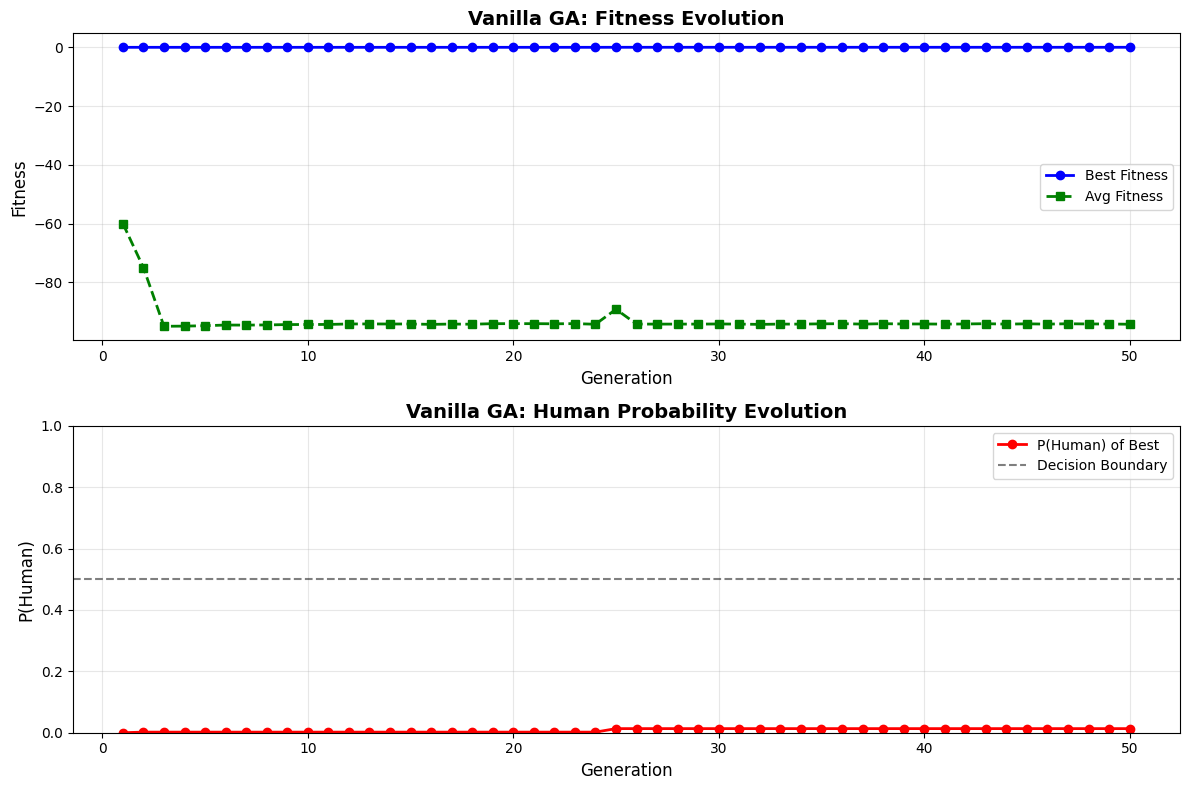


Visualization saved to vanilla_ga_evolution.png


In [15]:
# Cell 15: Visualize Evolution Progress
# Load data from CSV if history not available
if 'history' not in globals() or not history:
    print("Loading evolution data from CSV...")
    try:
        df = pd.read_csv(GA_CSV)
        
        # Aggregate by generation
        gen_stats = df.groupby('generation').agg({
            'fitness': ['max', 'mean'],
            'p_human': 'max'
        }).reset_index()
        
        gen_stats.columns = ['generation', 'best_fitness', 'avg_fitness', 'best_p_human']
        
        history = [
            {
                'generation': int(row['generation']),
                'best_fitness': float(row['best_fitness']),
                'avg_fitness': float(row['avg_fitness']),
                'best_p_human': float(row['best_p_human'])
            }
            for _, row in gen_stats.iterrows()
        ]
        print(f"Loaded {len(history)} generations from CSV")
    except Exception as e:
        print(f"ERROR loading CSV: {e}")
        history = []

if not history:
    print("No evolution data available. Run Cell 14 first.")
else:
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    generations = [h['generation'] for h in history]
    best_fitnesses = [h['best_fitness'] for h in history]
    avg_fitnesses = [h['avg_fitness'] for h in history]
    
    # Plot 1: Fitness over generations
    axes[0].plot(generations, best_fitnesses, 'b-o', label='Best Fitness', linewidth=2)
    axes[0].plot(generations, avg_fitnesses, 'g--s', label='Avg Fitness', linewidth=2)
    axes[0].set_xlabel('Generation', fontsize=12)
    axes[0].set_ylabel('Fitness', fontsize=12)
    axes[0].set_title('Vanilla GA: Fitness Evolution', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: P(Human) over generations
    p_humans = [h['best_p_human'] for h in history]
    axes[1].plot(generations, p_humans, 'r-o', label='P(Human) of Best', linewidth=2)
    axes[1].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Decision Boundary')
    axes[1].set_xlabel('Generation', fontsize=12)
    axes[1].set_ylabel('P(Human)', fontsize=12)
    axes[1].set_title('Vanilla GA: Human Probability Evolution', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('vanilla_ga_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to vanilla_ga_evolution.png")

## Cell 16: Compare Original vs Best

In [16]:
# Cell 16: Compare Original vs Best
print("=" * 80)
print("COMPARISON: ORIGINAL vs BEST VANILLA GA")
print("=" * 80)

# Load original and best if not available
if 'original_text' not in globals():
    with open(INPUT_FILE, "r", encoding="utf-8") as f:
        original_text = f.read().strip()

if 'best_individual' not in globals():
    # Load from logs
    evolution_files = list(GA_DIR.glob("generation_*.txt"))
    if evolution_files:
        evolution_files.sort(key=lambda x: int(x.stem.split('_')[1]))
        latest_file = evolution_files[-1]
        
        with open(latest_file, "r", encoding="utf-8") as f:
            content = f.read()
        
        text_marker = "\nText:\n"
        if text_marker in content:
            start_idx = content.index(text_marker) + len(text_marker)
            end_marker = "\n=========="
            if end_marker in content[start_idx:]:
                end_idx = content.index(end_marker, start_idx)
                best_individual = content[start_idx:end_idx].strip()

print("\n[ORIGINAL TEXT]")
print(original_text)
print()

probs_orig, pred_orig, conf_orig = get_classifier_predictions(original_text)
print(f"Classification:")
print(f"  P(Human): {probs_orig[0]:.4f}")
print(f"  P(AI): {probs_orig[1]:.4f}")
print(f"  P(AI-mimicry): {probs_orig[2]:.4f}")
print(f"  Predicted: Class {pred_orig+1} (conf={conf_orig:.4f})")

print("\n" + "=" * 80)
print("\n[BEST VANILLA GA TEXT]")
print(best_individual)
print()

probs_best, pred_best, conf_best = get_classifier_predictions(best_individual)
print(f"Classification:")
print(f"  P(Human): {probs_best[0]:.4f}")
print(f"  P(AI): {probs_best[1]:.4f}")
print(f"  P(AI-mimicry): {probs_best[2]:.4f}")
print(f"  Predicted: Class {pred_best+1} (conf={conf_best:.4f})")

print("\n" + "=" * 80)
print("\n[IMPROVEMENTS]")
print(f"P(Human) change: {probs_orig[0]:.4f} → {probs_best[0]:.4f} ({probs_best[0] - probs_orig[0]:+.4f})")
print(f"P(AI) change: {probs_orig[1]:.4f} → {probs_best[1]:.4f} ({probs_best[1] - probs_orig[1]:+.4f})")
print(f"Semantic similarity: {get_semantic_similarity(original_text, best_individual):.4f}")

if pred_best == 0:
    print("\n✓ SUCCESS: Vanilla GA achieved HUMAN classification!")
else:
    print(f"\n✗ Still classified as Class {pred_best+1}")
    
print("\n" + "=" * 80)
print("Compare this with MATE results to see the difference!")
print("=" * 80)

COMPARISON: ORIGINAL vs BEST VANILLA GA

[ORIGINAL TEXT]
The quiet hum of this neighborhood always felt like safety, a soft blanket of routine where the biggest scandal was usually a zoning dispute or an unkempt lawn. I honestly believed I knew the man living in the yellow bungalow across the street. He was the sort of person who returned borrowed tools early and bought Girl Scout cookies by the case, practically invisible in his decency. That illusion shattered the afternoon I accidentally opened his mail, a simple mix-up by the postman. The letter wasn't a utility bill or a birthday card; it was a heavily redacted government dossier with a photo of him looking twenty years younger and terrifyingly cold. Standing there on my porch, holding the envelope that felt suddenly heavy, I realized his gentle demeanor wasn't a personality trait. It was a camouflage, perfect and impenetrable, hiding a history that had no business existing between the library and the bakery.

Classification:
  P(

## Cell 17: MATE vs Vanilla GA Comparison

Run this after you've executed both MATE and Vanilla GA to see a side-by-side comparison.

In [17]:
# Cell 17: MATE vs Vanilla GA Comparison
print("=" * 80)
print("MATE vs VANILLA GA COMPARISON")
print("=" * 80)

# Try to load data from both algorithms
try:
    # Load Vanilla GA results
    df_ga = pd.read_csv(GA_CSV)
    ga_best = df_ga[df_ga['is_best'] == 1].copy()
    
    # Load MATE results
    mate_csv = Path("evolution.csv")
    if mate_csv.exists():
        df_mate = pd.read_csv(mate_csv)
        mate_best = df_mate[df_mate['is_best'] == 1].copy()
        
        # Create comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Best P(Human) over generations
        axes[0, 0].plot(ga_best['generation'], ga_best['p_human'], 
                       'b-o', label='Vanilla GA', linewidth=2, markersize=4)
        axes[0, 0].plot(mate_best['generation'], mate_best['p_human'], 
                       'r-s', label='MATE', linewidth=2, markersize=4)
        axes[0, 0].axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
        axes[0, 0].set_xlabel('Generation')
        axes[0, 0].set_ylabel('P(Human)')
        axes[0, 0].set_title('P(Human) Evolution: MATE vs Vanilla GA')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Fitness over generations
        axes[0, 1].plot(ga_best['generation'], ga_best['fitness'], 
                       'b-o', label='Vanilla GA', linewidth=2, markersize=4)
        axes[0, 1].plot(mate_best['generation'], mate_best['fitness'], 
                       'r-s', label='MATE', linewidth=2, markersize=4)
        axes[0, 1].set_xlabel('Generation')
        axes[0, 1].set_ylabel('Fitness')
        axes[0, 1].set_title('Fitness Evolution: MATE vs Vanilla GA')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Semantic similarity
        axes[1, 0].plot(ga_best['generation'], ga_best['semantic_similarity'], 
                       'b-o', label='Vanilla GA', linewidth=2, markersize=4)
        axes[1, 0].plot(mate_best['generation'], mate_best['semantic_similarity'], 
                       'r-s', label='MATE', linewidth=2, markersize=4)
        axes[1, 0].axhline(y=0.85, color='k', linestyle='--', alpha=0.5, label='Threshold')
        axes[1, 0].set_xlabel('Generation')
        axes[1, 0].set_ylabel('Semantic Similarity')
        axes[1, 0].set_title('Semantic Similarity: MATE vs Vanilla GA')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Final comparison bar chart
        final_ga = ga_best.iloc[-1]
        final_mate = mate_best.iloc[-1]
        
        metrics = ['P(Human)', 'Semantic\nSimilarity']
        ga_values = [final_ga['p_human'], final_ga['semantic_similarity']]
        mate_values = [final_mate['p_human'], final_mate['semantic_similarity']]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[1, 1].bar(x - width/2, ga_values, width, label='Vanilla GA', color='blue', alpha=0.7)
        axes[1, 1].bar(x + width/2, mate_values, width, label='MATE', color='red', alpha=0.7)
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].set_title('Final Performance Comparison')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(metrics)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        axes[1, 1].set_ylim([0, 1])
        
        plt.tight_layout()
        plt.savefig('mate_vs_vanilla_ga.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n✓ Comparison plot saved to mate_vs_vanilla_ga.png")
        
        # Print statistics
        print("\n" + "=" * 80)
        print("FINAL RESULTS COMPARISON")
        print("=" * 80)
        
        print(f"\nVanilla GA (Generation {final_ga['generation']:.0f}):")
        print(f"  P(Human): {final_ga['p_human']:.4f}")
        print(f"  P(AI): {final_ga['p_ai']:.4f}")
        print(f"  Fitness: {final_ga['fitness']:.4f}")
        print(f"  Semantic Similarity: {final_ga['semantic_similarity']:.4f}")
        print(f"  Predicted Class: {final_ga['predicted_class']:.0f}")
        
        print(f"\nMATE (Generation {final_mate['generation']:.0f}):")
        print(f"  P(Human): {final_mate['p_human']:.4f}")
        print(f"  P(AI): {final_mate['p_ai']:.4f}")
        print(f"  Fitness: {final_mate['fitness']:.4f}")
        print(f"  Semantic Similarity: {final_mate['semantic_similarity']:.4f}")
        print(f"  Predicted Class: {final_mate['predicted_class']:.0f}")
        
        print("\n" + "=" * 80)
        print("IMPROVEMENT (MATE vs Vanilla GA)")
        print("=" * 80)
        print(f"  ΔP(Human): {final_mate['p_human'] - final_ga['p_human']:+.4f}")
        print(f"  ΔFitness: {final_mate['fitness'] - final_ga['fitness']:+.4f}")
        print(f"  ΔSemantic Sim: {final_mate['semantic_similarity'] - final_ga['semantic_similarity']:+.4f}")
        
        if final_mate['p_human'] > final_ga['p_human']:
            improvement = ((final_mate['p_human'] - final_ga['p_human']) / final_ga['p_human'] * 100)
            print(f"\n✓ MATE achieved {improvement:.1f}% better P(Human) than Vanilla GA!")
        
    else:
        print("\n✗ MATE results (evolution.csv) not found.")
        print("Run the MATE notebook (mate.ipynb) first to generate comparison data.")
        
except FileNotFoundError as e:
    print(f"\n✗ Error: {e}")
    print("Make sure you've run both algorithms first.")
except Exception as e:
    print(f"\n✗ Unexpected error: {e}")
    import traceback
    traceback.print_exc()

MATE vs VANILLA GA COMPARISON

✗ Unexpected error: 'is_best'


Traceback (most recent call last):
  File "/home/samarth/Documents/precog-task/human-or-ai/venv2/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3641, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 168, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 197, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7668, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7676, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'is_best'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_109806/1664373863.py", line 10, in <module>
    ga_best = df_ga[df_ga['is_best'] == 1].copy()
                    ~~~~~^^^^^^^^^^^
  File "/home/samarth/Documents/precog-task/human-or-ai/